In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, precision_recall_fscore_support
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns

In [10]:
data = pd.read_csv("data_set_final2.csv", low_memory=False)

In [11]:
data.drop(columns=['rolling_avg_DESCIDA_PRECO','rolling_avg_AUMENTO_PRECO','rolling_avg_SKUS_DOWN','rolling_avg_items','rolling_avg_sales','rolling_avg_SKUS_UP'], inplace=True)

In [12]:
data['DATA_VENDA'] = pd.to_datetime(data['DATA_VENDA'])

# Calculate day of the week and median sales
data['day_of_week'] = data['DATA_VENDA'].dt.day_name()
median_sales = data.groupby(['LOJA', 'day_of_week'])['VALOR_VENDA'].median().reset_index()
median_sales.rename(columns={'VALOR_VENDA': 'median_sales'}, inplace=True)
data = pd.merge(data, median_sales, on=['LOJA', 'day_of_week'], how='left')

# Define the target categories based on median sales
def classify_sales(row):
    if row['VALOR_VENDA'] > row['median_sales'] * 1.1:
        return 'above'
    elif row['VALOR_VENDA'] < row['median_sales'] * 0.9:
        return 'below'
    else:
        return 'similar'

data['sales_category'] = data.apply(classify_sales, axis=1)

# Create lag and rolling mean features
data['lag_7'] = data.groupby('LOJA')['VALOR_VENDA'].shift(7)
data['rolling_mean_15'] = data.groupby('LOJA')['VALOR_VENDA'].shift(1).rolling(window=15).mean()

# Handle missing values
data['lag_7'].fillna(0, inplace=True)
data['rolling_mean_15'].fillna(data['rolling_mean_15'].mean(), inplace=True)

# Select specific features to include
selected_categorical_cols = ['day_of_week']  # Example: Include only 'day_of_week' and 'LOJA'
numeric_cols = ['TOTAL_COLABORADORES', 'SKUS','SKUS_UP','SKUS_DOWN','ITEMS','SELF_CHECKOUT','PRODUTIVIDADE_HORA','lag_7','rolling_mean_15']  # Example selected numeric features

# Setup the ColumnTransformer with OneHotEncoder for selected categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), selected_categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ])

# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

data_sorted = data.sort_values(by='DATA_VENDA')

# Prepare features and target
features = selected_categorical_cols + numeric_cols
X = data[features]
y = data['sales_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:')
print(class_report)

Accuracy: 0.7694756740622823
Classification Report:
              precision    recall  f1-score   support

       above       0.81      0.71      0.76      5437
       below       0.80      0.69      0.74      4674
     similar       0.74      0.84      0.79      9991

    accuracy                           0.77     20102
   macro avg       0.79      0.75      0.76     20102
weighted avg       0.77      0.77      0.77     20102



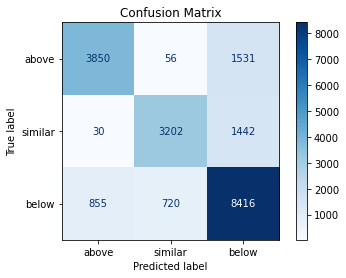

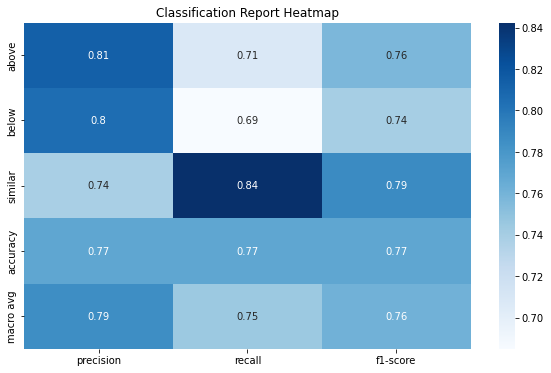

In [13]:
# Plot the confusion matrix with dynamic labels
labels = y_test.unique()
plot_confusion_matrix(pipeline, X_test, y_test, display_labels=labels, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report heatmap
class_report_dict = classification_report(y_test, y_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).T

plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, cmap='Blues')
plt.title('Classification Report Heatmap')
plt.show()

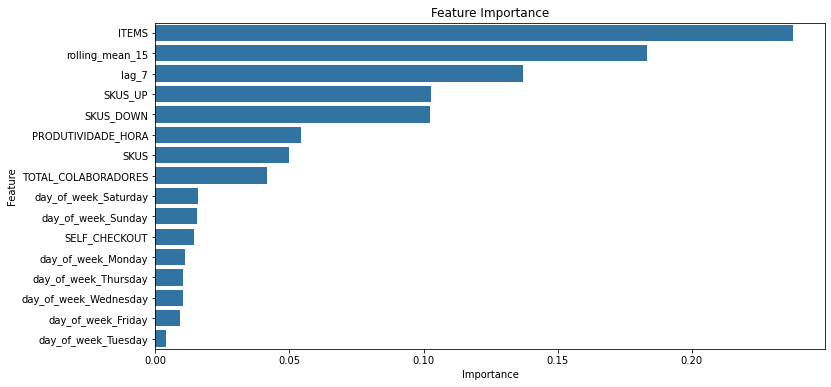

In [14]:
feature_importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = preprocessor.transformers_[0][1].get_feature_names(selected_categorical_cols).tolist() + numeric_cols
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

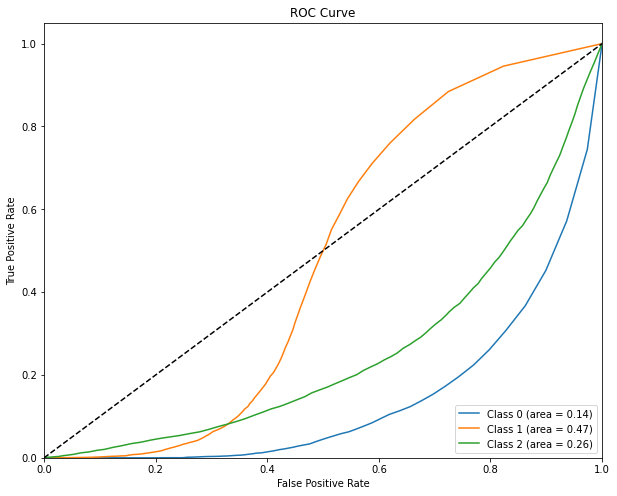

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=['below', 'similar', 'above'])
y_score = pipeline.predict_proba(X_test)

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y_test_bin[:, i], y_score[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

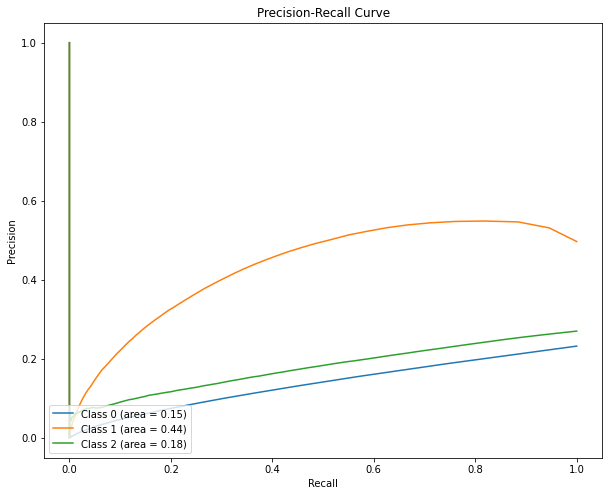

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'Class {i} (area = {average_precision_score(y_test_bin[:, i], y_score[:, i]):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

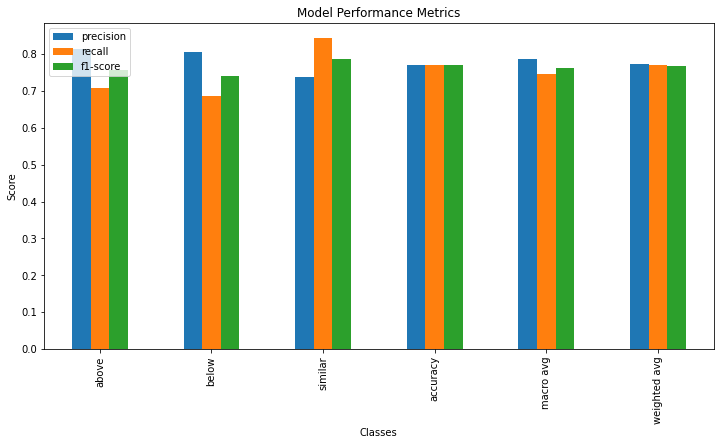

In [17]:
class_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
class_report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Metrics')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.show()